# Interactive INTRO to Fourier transform (FT)
  * I will not go deep into math, therefore some statements are not exact.
  * Goal is to provide motivation, why FT is such a strong and useful concept.

### Similarities and differences of Fourier series and Fourier transform
<table border="0">
 <tr>
    <td><b style="font-size:20px">Fourier series</b></td>
    <td><b style="font-size:20px">Fourier transform</b></td>
 </tr>
 <tr>
    <td>Only periodic functions</td>
    <td>Any function (periodic and more)</td>
 </tr>
 <tr>
    <td>Decomposes signal into frequency spectrum</td>
    <td>Decomposes signal into frequency spectrum</td>
 </tr>
 
 <tr>
    <td>Series of terms often infinite</td>
    <td>Always finite (same number as input)</td>
 </tr>


</table>

In this notebook I will present little bit how Fourier series work, and later in the projects you will mostly use Fourier transform, which is more practical.

1. Even though Fourier series can be composed of infinite number of terms, they are ordered by decreasing significance. This ensures you always take the most important terms first.
2. The rest of the terms are corrections to what you already have.

### Where is it used?
1. Compression (of images, music etc.)
2. Noise removal
3. Signal analysis (frequencies of sounds, light waves, etc.)
4. Spectroscopy and imaging, quantum mechanics, transport (heat etc.)

In [ ]:
## Only necessary to run this for Google colabs
import subprocess
import sys

def install_module(module):
    subprocess.call([sys.executable, "-m", "pip", "install", module])
    
install_module('dash')
install_module('jupyter_dash')

In [2]:
# scientific modules
import numpy as np
from scipy import signal, fft

# imports for interactive plots
from dash import Dash, html, dcc, Input, Output
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go

# standard plotting
import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams['figure.facecolor'] = 'white'

### Let's create a so called square function together with a simple sine.

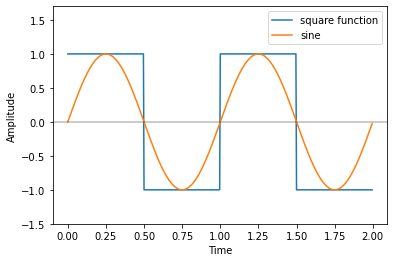

In [3]:
# our x axis, to think about oscillations in time, I call it t
t = np.linspace(0, 2, 500, endpoint=False)

# square function is famous, therefore it is present in signal module
plt.plot(t, signal.square(2 * np.pi * t), label='square function')
plt.plot(t, np.sin(2*np.pi*t), label='sine')
plt.axhline(0, color='k', lw=0.4)
plt.ylim(-1.5, 1.7)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

Square functions oscillates, which is good, but how on Earth can you produce the sharp edge just using sines and cosines?

---

It is a university level calculation, so we take just the result from wikipedia (if you want to see more details check [Wolfram explanation](https://mathworld.wolfram.com/FourierSeriesSquareWave.html)

\begin{align}
F(t)=\dfrac{4}{\pi}\sum_{k=1}^{\infty}{\dfrac{\sin{(2\pi(2k-1)ft)}}{2k-1}} = {\color{red}\dfrac{4}{\pi}}\left(\sin{({\color{green}\omega} t)} + {\color{red}\dfrac{1}{3}}\sin{({\color{green}3\omega} t)} + {\color{red}\dfrac{1}{5}}\sin{({\color{green}5\omega} t)} + ...\right)
\end{align}
, for $\omega=2\pi ft$.

### What does this mean?
If you look on the right side of the formula, you see that we are summing higher and higher frequencies (multiplying the $\omega$ with larger constant), but at the same time the amplitudes (constants in front of the sines) are getting smaller, which means they are less and less important.

This ordering of terms is the useful part, because it ensures that whatever number of terms we decide to take, we did the best possible job. The other terms improve the result, but less and less.

### Important
After Fourier transform, we plot frequencies on x axis (green terms) and their corresponding amplitudes on y axis (red numbers)

In [4]:
## fourier series
def ft_series_square(x_axis, freq, n_harmonics):
    # first create array of zeros, where I am going to add the sine terms
    f_values = np.zeros(len(x_axis))
    
    # k is the k from the formula above
    for k in range(1, n_harmonics+1):
        # for higher and higher frequencies, adding the sin term to my existing values
        f_values = f_values + np.sin(2*np.pi * (2*k-1) * freq * x_axis)/(2*k-1)

    # multiply only once the whole thing, insted of n_harmonics-times (in each iteration) 
    return f_values * 4/np.pi

## FFT stands for fast fourier transform, standard and fast algorithm to
# calculate FT if the x axis is equally spaced
def do_fft(x, f):
    # in principle this is all
    f_fft = fft.fft(f)

    # but in order to calculate correct x axis (frequencies)
    # we need to know so called step-size
    t_step = abs(x[1] - x[0])
    
    # FT amplitudes are also symmetric, so I take only half of the 
    # frequency interval
    x_fft = fft.fftfreq(len(x), t_step)[:len(x) // 2]

    return x_fft, 2.0/len(x) * np.abs(f_fft[0:len(x)//2])

## The following part is the interactive plotting definitions
  * It looks a bit complicated, feel free to skip. I am showing it here, because:
  * These plots integrate into html elements, so they can run on any webpage.
  * And can get you hired one day.
  
### In the end of the day we are calculating the same as above. 

1. FT spectrum (ie frequency amplitudes) on the right, frequencies on x, amplitudes on the y FOR EACH sine wave.
2. And left shows the result sum of sine waves from right plot and HOW it approximates the square function.

In [5]:
app = JupyterDash(__name__)
# whatever start with html. stands for html elements
# which have certain "style" defined (in CSS), that is why you typically
# learn html and CSS together.
app.layout = html.Div([
    html.H1('How FFT works.'),
    
    html.Div([
        html.Div([
            # left graph in separate div element
            dcc.Graph(id='time_domain_lines')
        ], style={'width':'49%', 'display': 'inline-block'}),
        html.Div([
            # right graph in other div element
            dcc.Graph(id='fft_lines')
        ], style={'width': '49%', 'display': 'inline-block'}),
        
        # title of size 4
        html.H4('Number of harmonics'),
        # div element which contains the slider
        html.Div(dcc.Slider(
            1, 20, step=1,
            id='n_harmonics_slider',
            value=1
        ), style={'width': '100%', 'display': 'inline-block'}),
    ], style={'width': '100%', 'display': 'inline-block'}),
    
    
], style={'backgroundColor':'white'})

# update left graph, when I move the slider
@app.callback(
    Output('time_domain_lines', 'figure'),
    Input('n_harmonics_slider', 'value'))

def update_graph(n_harmonics_value):
    # square function
    t = np.linspace(0, 2, 500, endpoint=False)
    f = ft_series_square(t, 1, n_harmonics_value)

    # initial plot of FT series (just a sine)
    fig = go.Figure()
    fig.add_trace(
        go.Line(
            x=t,
            y=f,
            name='FT series'),
        )

    # add square function line to the plot
    fig.add_trace(
        go.Line(
            x=t,
            y=signal.square(2 * np.pi * t),
            name='Square wave'),
        )
    # define graph labels
    fig.update_layout(
        yaxis_range=[-1.5,1.5],
        xaxis_title="Time",
        yaxis_title="Amplitude",
        )
    # add legend
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=1.2,
            xanchor="left",
            x=0.01),
        )
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        )
    return fig

# update right graph upon moving the slider
@app.callback(
    Output('fft_lines', 'figure'),
    Input('n_harmonics_slider', 'value'))

def create_fft(n_harmonics_value):
    # calculate FT by using do_fft() function
    t = np.linspace(0, 2, 500, endpoint=False)
    x, y = do_fft(t, ft_series_square(t, 1, n_harmonics_value))

    fig = go.Figure()  # define figure
    # add line plot
    fig.add_trace(go.Line(
                    x=x,
                    y=y),
                )
    # figure appearance, axis limits, margins, and labels.
    fig.update_layout(xaxis_range=[0,42])
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        xaxis_title="Frequency [1/Time]",
        yaxis_title="Amplitude",
        )
    return fig

In [6]:
del app.config._read_only["requests_pathname_prefix"]

In [7]:
app.run_server(mode='inline')

C:\Users\David Palecek\Documents\Python_projects\pymarad\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Good job, now is the time to check some application of FT:
1. Image compression.
2. Creating a new musical instrument.